In [2]:
import numpy as np
import os.path as op
from pandas import read_csv
import mne
from mne.io import read_raw_fif
from mne.datasets import visual_92_categories
from neurora.nps_cal import nps
from neurora.rdm_cal import eegRDM_bydecoding
from neurora.rdm_corr import rdm_correlation_spearman
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.rsa_plot import plot_rdm, plot_corrs_by_time, plot_nps_hotmap, plot_corrs_hotmap

1.6127106302172391


In [3]:
list_epochs_all = list()

sub_ids = [

     "pre4002_y","pre4003_y","pre4004_y","pre4005_y","pre4006_y"

]

file_path = 'E:\实验\阅读困难\数据处理\pre4\data\\6epoch_clean_RSA\\'
channels_nieye = ['M1','T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6']
channels_nieye = ['T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6']
channels_all = ['Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'PO8', 'O1', 'Oz', 'O2', ]
num_channels = len(channels_nieye)

for sub_id in sub_ids:
    data_path = file_path + sub_id + '_RSA-epo.fif'

    epochs_all = mne.read_epochs(fname=data_path)
    # 如果只想看某一部分的脑区,配合更改ndarray的维度
    epochs_all = epochs_all.pick(picks=channels_nieye)

    epochs_all.equalize_event_counts(method='mintime')

    list_epochs_all.append(epochs_all)

'''
思路，先求ERP，然后再给ndarray，然后再计算RDM
'''

Reading E:\实验\阅读困难\数据处理\pre4\data\6epoch_clean_RSA\pre4002_y_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1440 matching events found
No baseline correction applied
0 projection items activated
Dropped 0 epochs: 
Reading E:\实验\阅读困难\数据处理\pre4\data\6epoch_clean_RSA\pre4003_y_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1425 matching events found
No baseline correction applied
0 projection items activated
Dropped 49 epochs: 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 205, 411, 412, 413, 414, 415, 416, 417, 418, 422, 423, 424, 425, 440, 592, 620, 623, 625, 634, 641, 643, 644, 645, 658, 661, 1268, 1269, 1270, 1272, 1273, 1274, 1277, 1286, 1288, 1294, 1310, 1311, 1312
Reading E:\实验\阅读困难\数据处理\pre4\data\6epoch_clean_RSA\pre4004_y_RSA-epo.fif ...
    Found the data o

'\n思路，先求ERP，然后再给ndarray，然后再计算RDM\n'

In [4]:

'''
基础心理 学习 梁耀文:
路导，经过预处理之后，我的数据里每个被试的试次数量不一样（条件之间是一样的，用了mne的equalization），这样的数据该怎么放进去呢，还是说只能抽样到被试间的试次也相同？

基础心理 学习 梁耀文:
被试维度为1就行

基础心理 学习 梁耀文:
对被试循环

'''
conds = ['101', '102', '103', '104', '111', '112', '113', '114', '131', '132', '133', '134']


#初始值
subindex = 0
list_subdata = list()

for m in range(len(sub_ids)):
    #单个被试的数据
    epochs_forlen = list_epochs_all[m][conds[0]]#这里只是为了计算长度，随便写的0。
    # 每个被试的trial数量是不一样的
    # trial数不能放在第一位，第一位是condition
    subdata = np.zeros([16, len(epochs_forlen.events[:,1]), num_channels,  1001], dtype=np.float32)
    for i in range(len(conds)):
        epochs = list_epochs_all[m][conds[i]]
        #做decoding，这里就不能是平均了吧。
        # 这里get_data()还会把所有的channel都选上，你需要pick一下,只要eeg，不要眼动数据
        data = epochs.get_data(picks='eeg')
        subdata[i] = data
        # 现在是[con, trial, chan, ts]
        # [n_cons, n_subs, n_trials, n_chls, n_ts]需要这样的结构
        # 需要中间插入一个subs
    subdata = np.reshape(subdata, [16, 1, len(epochs_forlen.events[:,1]), num_channels, 1001])
    list_subdata.append(subdata)


In [5]:
#单个被试的RDMS
rdms_allsub = list()
for i in range(len(sub_ids)):
    subrdms = eegRDM_bydecoding(list_subdata[i], time_win=50, time_step=5, navg=5)
    rdms_allsub.append(subrdms)

(1, 180, 11, 1001)
(1, 180)
Calculating: [====================================================================================================] 100.00%
Decoding finished!

(1, 180, 11, 1001)
(1, 180)
Calculating: [====================================================================================================] 100.00%
Decoding finished!

(1, 180, 11, 1001)
(1, 180)
Calculating: [====================================================================================================] 100.00%
Decoding finished!

(1, 180, 11, 1001)
(1, 180)
Calculating: [====================================================================================================] 100.00%
Decoding finished!

(1, 180, 11, 1001)
(1, 180)
Calculating: [====================================================================================================] 100.00%
Decoding finished!

(1, 180, 11, 1001)
(1, 180)
Calculating: [==================================================================================================

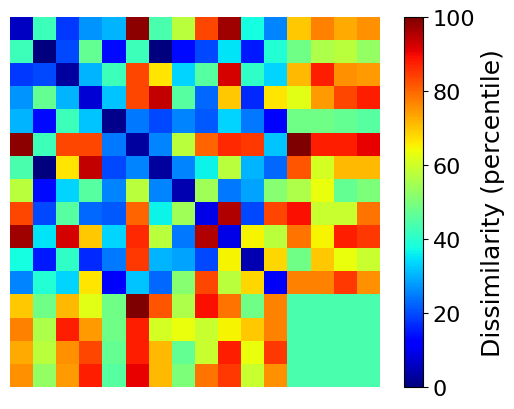

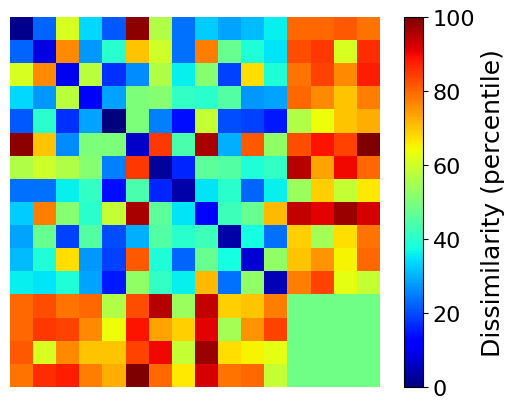

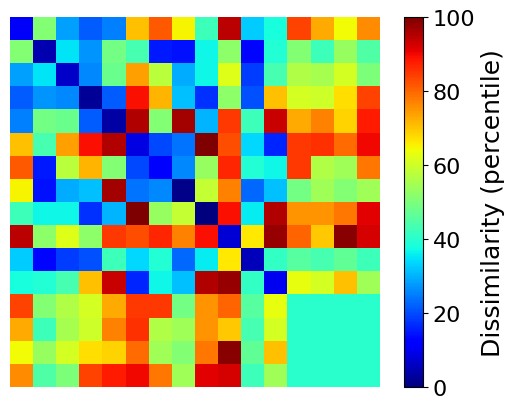

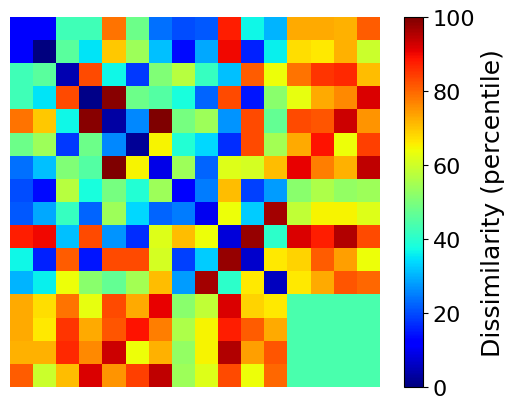

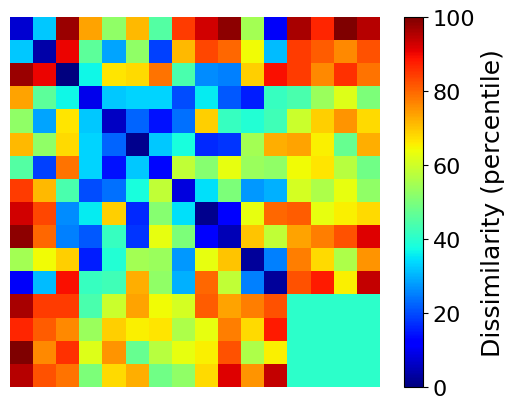

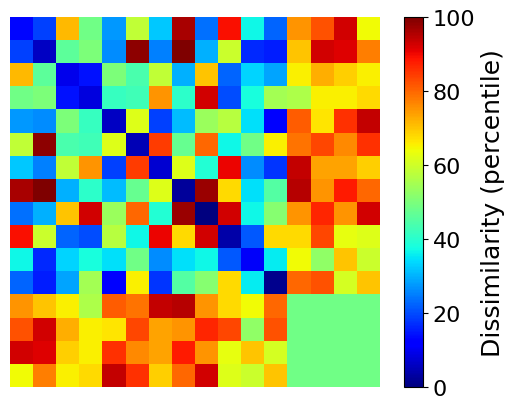

In [6]:
# Plot the RDM of -100ms, 0ms, 50ms, 100ms, 150ms, 200ms
times = [0, 10, 20, 30, 40, 50,]
for t in times:
    plot_rdm(subrdms[0,t], percentile=True)

In [8]:
'''
构造模型矩阵
'''

RDM_model_fuyin = np.zeros([16,16], dtype=np.float32)
# for i in range(20):
#     for j in range(20):
#         if abs(i-j)<=3:
#             RDM_model_fuyin[i,j] = 0
#         else:
#             RDM_model_fuyin[i,j] =
zeroM = np.zeros([4,4], dtype=np.float32)
oneM =  np.ones((4, 4), dtype=np.float32)

a1=np.concatenate((zeroM,oneM,oneM,oneM),axis = 1)
a2=np.concatenate((oneM,zeroM,oneM,oneM),axis = 1)
a3=np.concatenate((oneM,oneM,zeroM,oneM),axis = 1)
a4=np.concatenate((oneM,oneM,oneM,zeroM),axis = 1)

RDM_model_fuyin = np.concatenate((a1,a2,a3,a4),axis=0)


In [9]:
# Calculate the representational similarity between 200ms and all the time points
# （sub,times,2）
# 所有被试的 corrs
corrs_allsubs = np.zeros([len(sub_ids),191,2], dtype=np.float32)
for j in range(len(sub_ids)):
    #每个被试的corrs
    corrs1 = rdms_corr(RDM_model_fuyin, rdms_allsub[j])
    corrs_allsubs[j] = corrs1


Computing similarities

Computing finished!

Computing similarities

Computing finished!

Computing similarities

Computing finished!

Computing similarities

Computing finished!

Computing similarities

Computing finished!



Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
310ms to 334ms


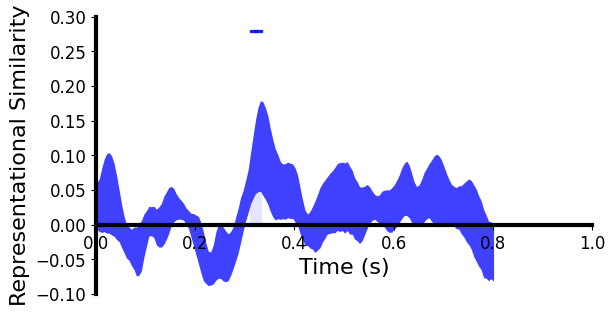

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [13]:
%matplotlib inline
# Plot the corrs1
# corrs1 = np.reshape(corrs1, [1, 191, 2])
# plot_corrs_by_time(corrs1, time_unit=[-0.2, 0.005])
from neurora.rsa_plot import plot_tbytsim_withstats
#配合RDMS的时间窗是 50ms，步长是5ms = 0.005
# 为甚画出来是空的图呢？因为你就一个被试啊。。统计不了

#多被试作图
plot_tbytsim_withstats(corrs_allsubs, start_time=-0.15, end_time=0.805, time_interval=0.005, p=0.08,clusterp=0.05,stats_time=[0,0.8],ylim=[-0.1,0.3], color='blue')

# 单被试作图查看
# plot_corrs_by_time(corrs1, time_unit=[-0.2, 0.005])


In [14]:

'''
构造模型矩阵
'''

RDM_model_yindiao = np.zeros([16,16], dtype=np.float32)


oneM =  np.ones((4, 4), dtype=np.float32)
for i in range(4):
    oneM[i][i] = 0
zeroM = oneM

a1=np.concatenate((zeroM,oneM,oneM,oneM,),axis = 1)
a2=np.concatenate((oneM,zeroM,oneM,oneM,),axis = 1)
a3=np.concatenate((oneM,oneM,zeroM,oneM,),axis = 1)
a4=np.concatenate((oneM,oneM,oneM,zeroM,),axis = 1)

RDM_model_yindiao = np.concatenate((a1,a2,a3,a4),axis=0)

In [15]:
# Calculate the representational similarity between 200ms and all the time points
corrs_allsubs_yindiao = np.zeros([len(sub_ids),191,2], dtype=np.float32)
for j in range(len(sub_ids)):
    #每个被试的corrs
    corrs1 = rdms_corr(RDM_model_yindiao, rdms_allsub[j])
    corrs_allsubs_yindiao[j] = corrs1



Computing similarities

Computing finished!

Computing similarities

Computing finished!

Computing similarities

Computing finished!

Computing similarities

Computing finished!

Computing similarities

Computing finished!



Significant time-windows:


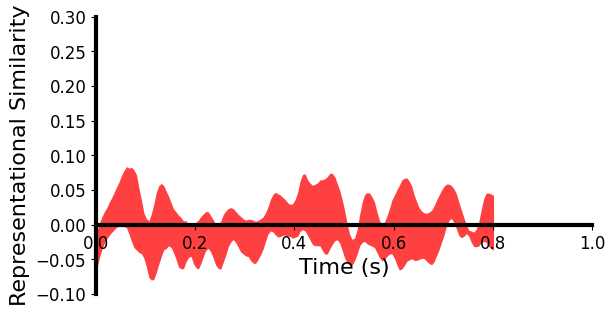

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [16]:
plot_tbytsim_withstats(corrs_allsubs_yindiao, start_time=-0.15, end_time=0.805, time_interval=0.005, p=0.05,clusterp=0.05,stats_time=[0,0.8],ylim=[-0.1,0.3], color='red')

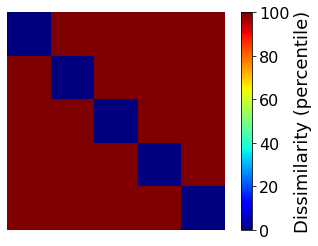

0

In [24]:
plot_rdm(RDM_model_fuyin, percentile=True)

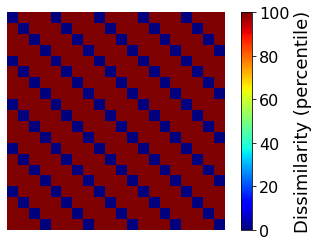

0

In [25]:
plot_rdm(RDM_model_yindiao, percentile=True)